<a href="https://colab.research.google.com/github/aa23amd/HYBRID-ML-BASED-SUB-SEASONAL-WEATHER-FORECASTING/blob/main/xgboost_evaluation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


data loading and preprocessing

In [4]:
import pandas as pd
!unzip -o "/content/drive/MyDrive/train_data.csv.zip" -d /content/

# Update the path to your dataset on Drive.
csv_path = "/content/train_data.csv"
train_df = pd.read_csv(csv_path)

# Load the dataset
df = pd.read_csv('/content/train_data.csv')

# Target variable: 14-day temperature forecast
target_column = 'contest-tmp2m-14d__tmp2m'

# Drop irrelevant columns
df.drop(['startdate', 'climateregions__climateregion'], axis=1, errors='ignore', inplace=True)

# Drop rows with missing target
df = df[df[target_column].notnull()]

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Clean numeric features
X = X.apply(pd.to_numeric, errors='coerce').fillna(X.median())


Archive:  /content/drive/MyDrive/train_data.csv.zip
  inflating: /content/train_data.csv  


explonatory data analysis

distribution of target

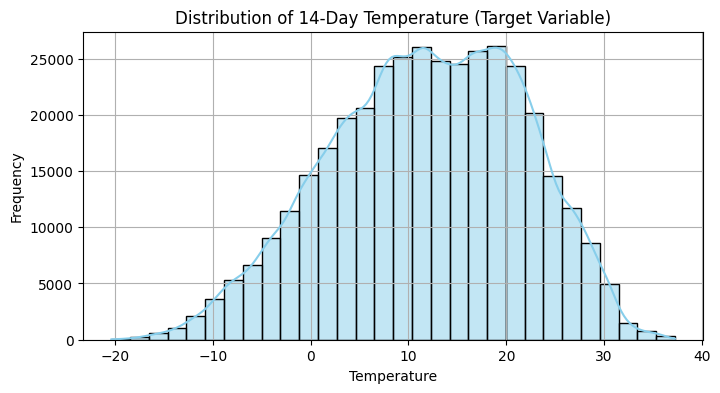

In [5]:
plt.figure(figsize=(8, 4))
sns.histplot(y, bins=30, kde=True, color='skyblue')
plt.title("Distribution of 14-Day Temperature (Target Variable)")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


corelation heatmap

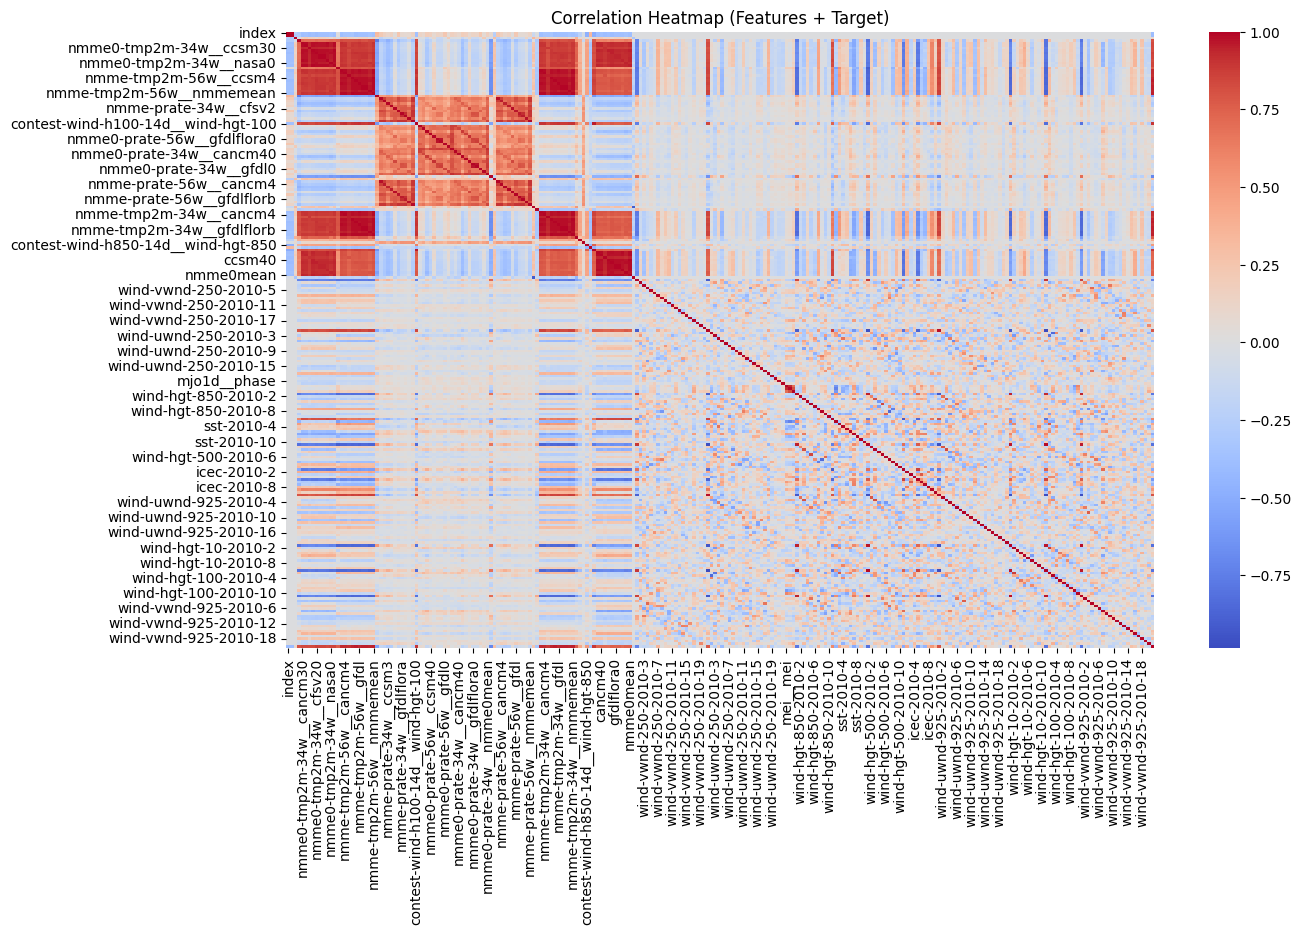

In [6]:
df_corr = X.copy()
df_corr['target'] = y
plt.figure(figsize=(14, 8))
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (Features + Target)")
plt.show()


correlated features

In [7]:
correlations = df_corr.corr()['target'].drop('target').sort_values(ascending=False)
print("🔍 Top 10 positively correlated features:\n", correlations.head(10))
print("\n🔍 Top 10 negatively correlated features:\n", correlations.tail(10))


🔍 Top 10 positively correlated features:
 nmme-tmp2m-56w__cfsv2        0.954668
nmme-tmp2m-34w__cfsv2        0.954483
nmme-tmp2m-56w__nmmemean     0.950865
nmme-tmp2m-34w__nmmemean     0.950187
nmme-tmp2m-56w__gfdlflora    0.949846
nmme-tmp2m-34w__gfdlflorb    0.949346
nmme-tmp2m-56w__gfdlflorb    0.949016
nmme-tmp2m-34w__gfdlflora    0.947379
nmme-tmp2m-56w__ccsm4        0.944435
nmme-tmp2m-34w__ccsm4        0.943234
Name: target, dtype: float64

🔍 Top 10 negatively correlated features:
 sst-2010-7                      -0.517767
contest-rhum-sig995-14d__rhum   -0.565127
icec-2010-5                     -0.603640
contest-slp-14d__slp            -0.707640
wind-vwnd-250-2010-1            -0.731919
wind-hgt-850-2010-1             -0.779923
wind-hgt-100-2010-1             -0.802240
wind-hgt-500-2010-1             -0.806078
wind-vwnd-925-2010-1            -0.807371
wind-hgt-10-2010-1              -0.815701
Name: target, dtype: float64


splitting and scalling

In [8]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
training xgboost

In [9]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

evaluation matrics

In [13]:
# Predict
y_pred = model.predict(X_test_scaled)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
accuracy = np.mean(np.abs(y_test - y_pred) <= 2.0) * 100

print(f"✅ MAE: {mae:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")
print(f"✅ Accuracy (±2°C): {accuracy:.2f}%")





✅ MAE: 0.6703
✅ RMSE: 0.8606
✅ R² Score: 0.9924
✅ Accuracy (±2°C): 97.38%


visualization

actual vs predicted

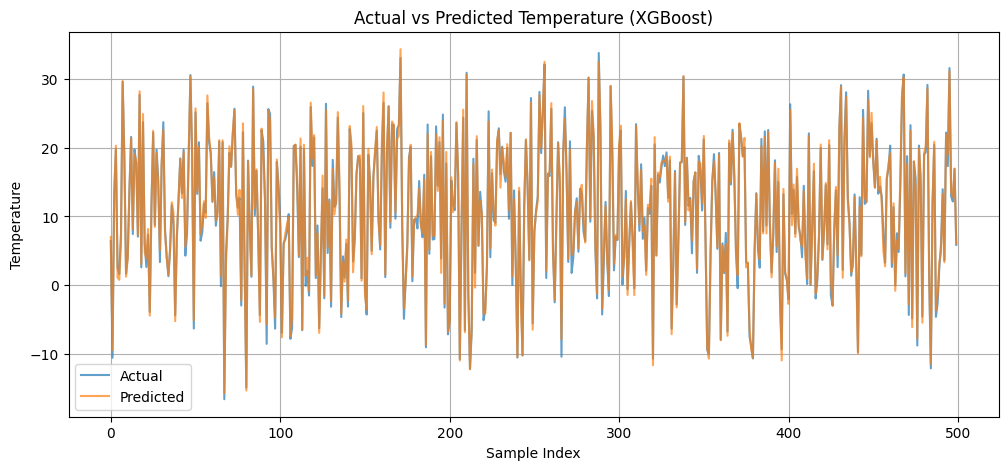

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:500], label="Actual", alpha=0.7)
plt.plot(y_pred[:500], label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Temperature (XGBoost)")
plt.xlabel("Sample Index")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()


Explanation: Actual vs Predicted Temperature (XGBoost)
This line chart compares the true temperature values (y_test) from the dataset with the temperature values predicted by the XGBoost model (y_pred) for the first 500 samples in the test set.


 What the plot shows:
The X-axis represents the sample index (1 to 500).

The Y-axis shows the temperature values.

The blue line represents the actual observed temperatures.

The orange line represents the model’s predicted temperatures.

 Why this plot is useful:
If the two lines are very close together, it means the model is making accurate predictions.

Where the lines diverge, the model’s predictions are less accurate.

This visual representation gives an immediate sense of how well the model is tracking the real data over time or sample index.

 Interpretation:
If most parts of the predicted line closely follow the actual line, your model is doing a good job. If there are major gaps, the model might need improvement. From your plot, if the lines generally follow the same pattern with small differences, it's a strong result from XGBoost.



residual plot

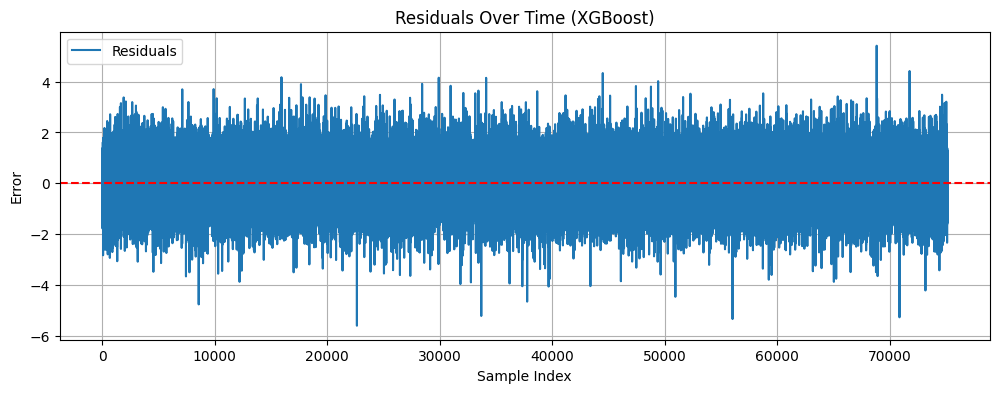

In [14]:
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.plot(residuals.values, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time (XGBoost)")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


histogram actual vs predicted

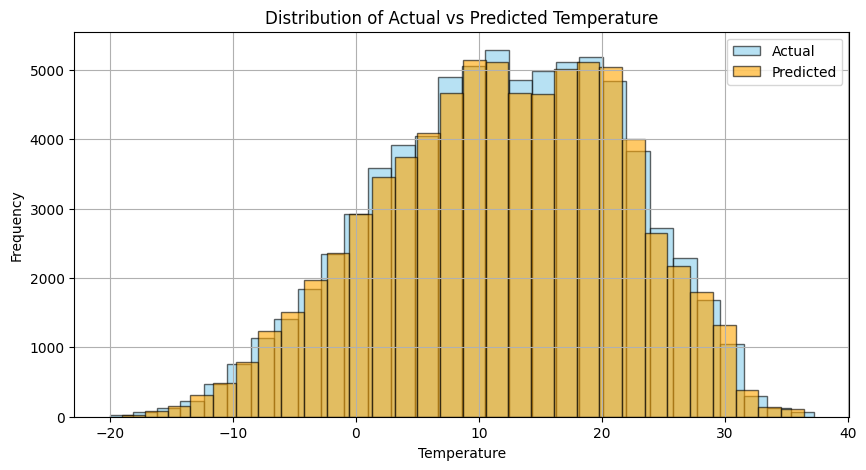

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(y_test, bins=30, alpha=0.6, label="Actual", color="skyblue", edgecolor='black')
plt.hist(y_pred, bins=30, alpha=0.6, label="Predicted", color="orange", edgecolor='black')
plt.title("Distribution of Actual vs Predicted Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


 Explanation: Distribution of Actual vs Predicted Temperature
This overlaid histogram compares the distribution of the actual and predicted temperature values in the test dataset using the XGBoost model.

 What Each Part of the Plot Represents:
X-axis (Horizontal Axis):
Shows the temperature values.

It is divided into bins (temperature ranges), typically of equal width.

Each bin groups temperature values into a range, such as 10–12°C, 12–14°C, etc.

 Y-axis (Vertical Axis):
Represents the frequency (i.e., how many values fall into each temperature bin).

For example, if 200 actual temperature values fall between 12–14°C, that bin will rise to height 200.

 Sky Blue Bars  Actual Values:
These bars show the true observed temperatures from the dataset.

They help us understand how temperatures are distributed in reality.

 Orange Bars  Predicted Values:
These show how the model’s predictions are distributed.

They should ideally match or closely follow the shape of the actual (blue) bars.



heatmap:features+actual+predicted

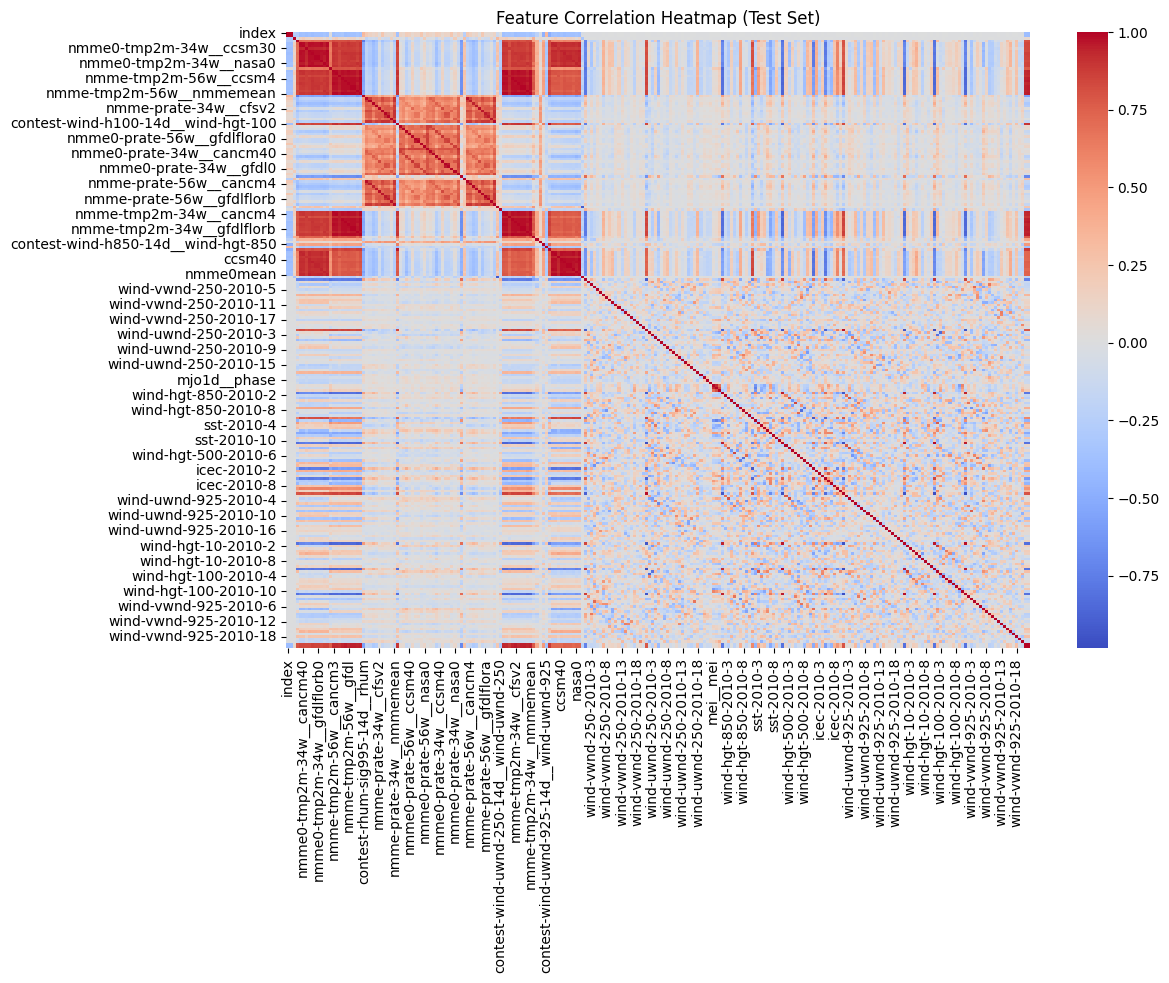

In [16]:
test_df = X_test.copy()
test_df['Actual'] = y_test
test_df['Predicted'] = y_pred

plt.figure(figsize=(12, 8))
sns.heatmap(test_df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap (Test Set)")
plt.show()
